In [1]:
# Notebook settings
from importlib import reload
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

In [2]:
# Default
import os
import urllib.request
import sys
import pandas as pd
import numpy as np


# import deeplc packages
from deeplc import DeepLC
from deeplcretrainer import deeplcretrainer
import tensorflow as tf
from tensorflow.python.eager import context

2023-11-29 14:51:45,547 - numexpr.utils - INFO - Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2023-11-29 14:51:45,548 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.


In [3]:
# Global settings

seed = 42
working_dir = '/mnt/cmnfs/home/z.xiao/miniconda3/envs/dlomix/lib'

# add custom modules
module_path = '/mnt/cmnfs/proj/ORIGINS/protMSD/maxquant/ScanByScan'
if module_path not in sys.path:
    sys.path.append(module_path)

os.chdir(working_dir)
tf.random.set_seed(seed)
tf.debugging.set_log_device_placement(True)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


# Prepare input data
Input data from maxquant evidence.txt, column 'MS/MS scan number' --> 'Scan number'

In [4]:
import importlib
import prediction.RT
reload(prediction.RT)
from prediction.RT import prepare_MQ_evidence, format_MQ_as_DeepLCinput, match_pred_to_input

<module 'prediction.RT' from '/mnt/cmnfs/proj/ORIGINS/protMSD/maxquant/ScanByScan/prediction/RT.py'>

In [7]:
DDA_evidence_file =  '/mnt/cmnfs/proj/ORIGINS/data/ecoli/ss/DDA/MQ/combined/txt/evidence.txt'
DDA_evidence_tranfer_file, DDA_evidence_file_transfer_pred, DDA_evidence_transfer_pred_Iso = prepare_MQ_evidence(maxquant_evidence_filepath=DDA_evidence_file)
hphrp_evidence_file = '/mnt/cmnfs/proj/ORIGINS/data/ecoli/HpHRP/MQ/1FDR/combined/txt/evidence.txt'
hphrp_evidence_tranfer_file, hphrp_evidence_file_transfer_pred, hphrp_evidence_transfer_pred_Iso = prepare_MQ_evidence(maxquant_evidence_filepath=hphrp_evidence_file)

In [8]:
DDA_MQ_peprec, DDA_peprec_agg = format_MQ_as_DeepLCinput(DDA_evidence_tranfer_file)
hphrp_MQ_peprec, hphrp_peprec_agg = format_MQ_as_DeepLCinput(hphrp_evidence_tranfer_file)


In [9]:
DDA_MQ = pd.read_csv(DDA_evidence_file, sep='\t', index_col=0)

In [10]:
for exp_num in [1, 2, 3, 4, 5]:
    DDA_MQ_exp = DDA_MQ.loc[DDA_MQ['Experiment'] == exp_num]
    print(DDA_MQ_exp.shape)
    DDA_MQ_exp.to_csv(os.path.join(os.path.dirname(DDA_evidence_file), 'evidence_'+str(exp_num)+'.txt'), sep='\t')

(19186, 60)
(19309, 60)
(19031, 60)
(19203, 60)
(19196, 60)


# Calibration and Transfer learing
Here only DDA data is used for transfer learning

In [12]:
# Variables
train_frac = 0.9
exp_dir = '/mnt/cmnfs/proj/ORIGINS/data/ecoli/SBS_exp/'
cal_pred_col = 'cal_pred_'+str(train_frac)
trans_pred_col = 'trans_pred_'+str(train_frac)

# Paths
exp_dir = os.path.join(exp_dir, 'RT_tranfer_learn')
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
#test_file_save = os.path.join(exp_dir, 'df_test_'+str(train_frac)+'.csv')
transfer_learn_data_file = os.path.join(exp_dir, 'evidence_RT_transfer.csv')


if not os.path.exists(os.path.join(exp_dir, 'models')):
    os.makedirs(os.path.join(exp_dir, 'models'))
ori_model_paths = [
    os.path.join(exp_dir, 'models',"full_hc_train_pxd001468_1fd8363d9af9dcad3be7553c39396960.hdf5"),
    os.path.join(exp_dir, 'models',"full_hc_train_pxd001468_8c22d89667368f2f02ad996469ba157e.hdf5"),
    os.path.join(exp_dir, 'models',"full_hc_train_pxd001468_cb975cfdd4105f97efa0b3afffe075cc.hdf5")
]

train_file = os.path.join(exp_dir, "train.csv")
df_file = os.path.join(exp_dir, "evidence_RT_pred.csv")

In [ ]:
# obtain three default models for deeplc
# need to use the raw file link to download
# url = "https://raw.githubusercontent.com/organization/repo/branch/folder/file"
urllib.request.urlretrieve(
    "https://raw.githubusercontent.com/compomics/DeepLC/master/deeplc/mods/full_hc_PXD005573_mcp_1fd8363d9af9dcad3be7553c39396960.hdf5",
    ori_model_paths[0]
)
urllib.request.urlretrieve(
    "https://raw.githubusercontent.com/compomics/DeepLC/master/deeplc/mods/full_hc_PXD005573_mcp_8c22d89667368f2f02ad996469ba157e.hdf5",
    ori_model_paths[1]
)

urllib.request.urlretrieve(
    "https://raw.githubusercontent.com/compomics/DeepLC/master/deeplc/mods/full_hc_PXD005573_mcp_cb975cfdd4105f97efa0b3afffe075cc.hdf5",
    ori_model_paths[2]
)


('/mnt/cmnfs/proj/ORIGINS/data/ecoli/SBS_exp/RT_tranfer_learn/models/full_hc_train_pxd001468_1fd8363d9af9dcad3be7553c39396960.hdf5',
 <http.client.HTTPMessage at 0x7f710c6928f0>)

('/mnt/cmnfs/proj/ORIGINS/data/ecoli/SBS_exp/RT_tranfer_learn/models/full_hc_train_pxd001468_8c22d89667368f2f02ad996469ba157e.hdf5',
 <http.client.HTTPMessage at 0x7f710c6903d0>)

('/mnt/cmnfs/proj/ORIGINS/data/ecoli/SBS_exp/RT_tranfer_learn/models/full_hc_train_pxd001468_cb975cfdd4105f97efa0b3afffe075cc.hdf5',
 <http.client.HTTPMessage at 0x7f710c6915d0>)

In [13]:
# load DDA transfer learning data and split
df = DDA_peprec_agg
df_train = df.sample(frac=train_frac, random_state = seed)
df_test = df.loc[df.index.difference(df_train.index)]

df_train.fillna("",inplace=True)
df_test.fillna("",inplace=True)


## Calibration Only

In [14]:
%%capture

# The following code is not required in most cases, but here it is used to 
# clear variables that might cause problems
_ = tf.Variable([1])

context._context = None
context._create_context()

tf.config.threading.set_inter_op_parallelism_threads(1)

# Make sure we have no NA in the dataframes
df_test['modifications'] = df_test['modifications'].fillna("")
df_train['modifications'] = df_train['modifications'].fillna("")

# Call DeepLC with the downloaded models, say that we use GAM calibration
dlc = DeepLC(
        path_model=ori_model_paths,
        batch_num=1024000,
        pygam_calibration=True
)

# Perform calibration, make predictions and calculate metrics
dlc.calibrate_preds(seq_df=df_train)
df_test[cal_pred_col] = dlc.make_preds(seq_df=df_test)


## Transfer Learning

In [14]:
# The following code is not required in most cases, but here it is used to clear variables that might cause problems
_ = tf.Variable([1])

context._context = None
context._create_context()

tf.config.threading.set_inter_op_parallelism_threads(1)

# For training new models we need to use a file, so write the train df to a file
df_train.to_csv(train_file,index=False)



# Here we will apply transfer learning we specify previously trained models in the 'mods_transfer_learning'
models = deeplcretrainer.retrain(
    [train_file],
    mods_transfer_learning=ori_model_paths,
    freeze_layers=True,
    n_epochs=10,
    freeze_after_concat=1
);

# The following code is not required in most cases, but here it is used to clear variables that might cause problems
_ = tf.Variable([1])

context._context = None
context._create_context()

tf.config.threading.set_inter_op_parallelism_threads(1)

# Make a DeepLC object with the models trained previously
dlc_trans = DeepLC(
        path_model=models,
        batch_num=1024000,
        pygam_calibration=False
)

# Perform calibration, make predictions and calculate metrics
dlc_trans.calibrate_preds(seq_df=df_train)
df_test[trans_pred_col] = dlc_trans.make_preds(seq_df=df_test)

Exception ignored in: <function _EagerDefinedFunctionDeleter.__del__ at 0x7f7140b94af0>
Traceback (most recent call last):
  File "/home/zixuanxiao/miniconda3/envs/py310/lib/python3.10/site-packages/tensorflow/python/eager/polymorphic_function/monomorphic_function.py", line 172, in __del__
    context.remove_function(self.name)
  File "/home/zixuanxiao/miniconda3/envs/py310/lib/python3.10/site-packages/tensorflow/python/eager/context.py", line 2724, in remove_function
    context().remove_function(name)
  File "/home/zixuanxiao/miniconda3/envs/py310/lib/python3.10/site-packages/tensorflow/python/eager/context.py", line 1387, in remove_function
    pywrap_tfe.TFE_ContextRemoveFunction(self._handle, name)
tensorflow.python.framework.errors_impl.InvalidArgumentError: Tried to remove non-existent function '__inference_predict_function_20975'.
2023-11-10 10:30:02,061 - deeplc.deeplc - WARNING - DeepLC tried to set intra op threads, but was unable to do so.


Epoch 1/10
130/130 [==============================] - 5s 24ms/step - loss: 1.7752 - mean_absolute_error: 1.7604 - val_loss: 0.5239 - val_mean_absolute_error: 0.5092
Epoch 2/10
130/130 [==============================] - 3s 22ms/step - loss: 0.4732 - mean_absolute_error: 0.4584 - val_loss: 0.4694 - val_mean_absolute_error: 0.4546
Epoch 3/10
130/130 [==============================] - 3s 22ms/step - loss: 0.4501 - mean_absolute_error: 0.4353 - val_loss: 0.5023 - val_mean_absolute_error: 0.4875
Epoch 4/10
130/130 [==============================] - 3s 21ms/step - loss: 0.4226 - mean_absolute_error: 0.4078 - val_loss: 0.5031 - val_mean_absolute_error: 0.4883
Epoch 5/10
130/130 [==============================] - 3s 22ms/step - loss: 0.4139 - mean_absolute_error: 0.3991 - val_loss: 0.4730 - val_mean_absolute_error: 0.4582
Epoch 6/10
130/130 [==============================] - 3s 21ms/step - loss: 0.4038 - mean_absolute_error: 0.3890 - val_loss: 0.4381 - val_mean_absolute_error: 0.4233
Epoch 7/10

Exception ignored in: <function _EagerDefinedFunctionDeleter.__del__ at 0x7f7140b94af0>
Traceback (most recent call last):
  File "/home/zixuanxiao/miniconda3/envs/py310/lib/python3.10/site-packages/tensorflow/python/eager/polymorphic_function/monomorphic_function.py", line 172, in __del__
    context.remove_function(self.name)
  File "/home/zixuanxiao/miniconda3/envs/py310/lib/python3.10/site-packages/tensorflow/python/eager/context.py", line 2724, in remove_function
    context().remove_function(name)
  File "/home/zixuanxiao/miniconda3/envs/py310/lib/python3.10/site-packages/tensorflow/python/eager/context.py", line 1387, in remove_function
    pywrap_tfe.TFE_ContextRemoveFunction(self._handle, name)
tensorflow.python.framework.errors_impl.InvalidArgumentError: Tried to remove non-existent function '__inference_Dataset_map_grab_batch_22807'.
Exception ignored in: <function _EagerDefinedFunctionDeleter.__del__ at 0x7f7140b94af0>
Traceback (most recent call last):
  File "/home/zixuan

19/19 [==============================] - 11s 539ms/step


{}

3/3 [==============================] - 1s 271ms/step


In [15]:
df['predicted_RT'] = dlc_trans.make_preds(seq_df=df)
df.to_csv(df_file, index = False)

22/22 [==============================] - 12s 508ms/step


# Evaluate

In [16]:
from utils.metrics import RT_metrics

MAE:  0.5316118943002592
Delta RT 95%:  2.7332214230723193
Pearson Corr:  0.9964445547122283
Green line shows deltaRT 95
Data:  tr cal_pred_0.9 , slope =  0.991 , intercept =  0.157 , PearsonR =  0.996 , SpearmanR =  0.996


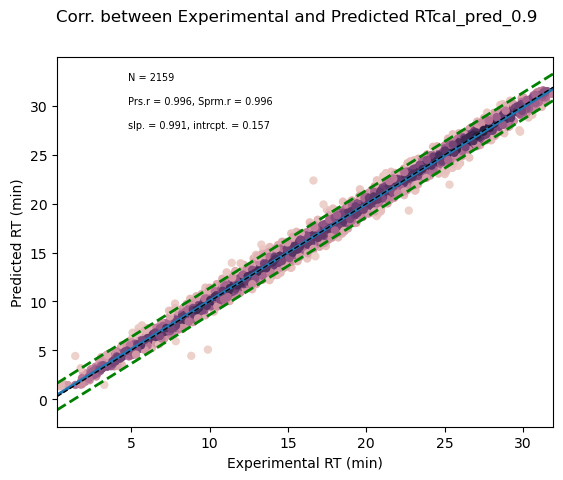

In [17]:
# calibration result
%matplotlib inline
RTmetric = RT_metrics(RT_obs = df_test["tr"], RT_pred = df_test[cal_pred_col])
print('MAE: ', RTmetric.CalcMAE())
print('Delta RT 95%: ', RTmetric.CalcDeltaRTwidth(95))
print('Pearson Corr: ', RTmetric.CalcPrsCorr())
RTmetric.PlotRTScatter()

MAE:  0.38600307099986025
Delta RT 95%:  1.908865443036275
Pearson Corr:  0.995583707707462
Green line shows deltaRT 95
Data:  tr predicted_RT , slope =  0.993 , intercept =  0.13 , PearsonR =  0.996 , SpearmanR =  0.996


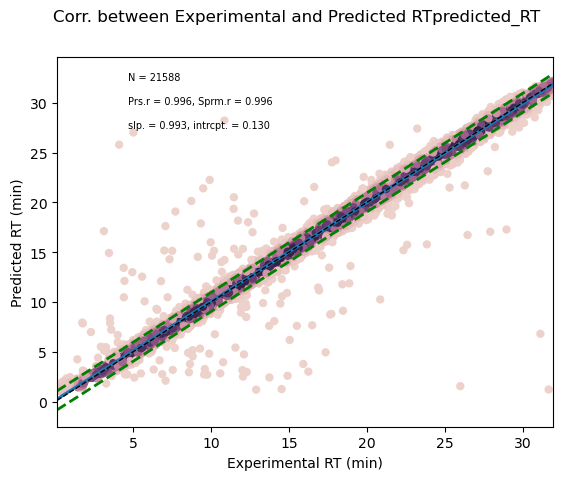

In [18]:
# transfer learning result: all
%matplotlib inline
RTmetric = RT_metrics(RT_obs = df["tr"], RT_pred = df['predicted_RT'])
print('MAE: ', RTmetric.CalcMAE())
print('Delta RT 95%: ', RTmetric.CalcDeltaRTwidth(95))
print('Pearson Corr: ', RTmetric.CalcPrsCorr())
RTmetric.PlotRTScatter()

MAE:  0.3588671149381527
Delta RT 95%:  1.906417953816692
Pearson Corr:  0.998196056424567
Green line shows deltaRT 95
Data:  tr trans_pred_0.9 , slope =  0.995 , intercept =  0.084 , PearsonR =  0.998 , SpearmanR =  0.998


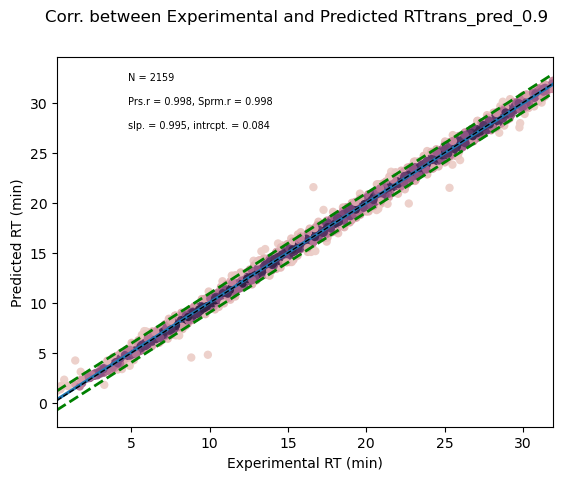

In [19]:
# transfer learning result: test
%matplotlib inline
RTmetric = RT_metrics(RT_obs = df_test["tr"], RT_pred = df_test[trans_pred_col])
print('MAE: ', RTmetric.CalcMAE())
print('Delta RT 95%: ', RTmetric.CalcDeltaRTwidth(95))
print('Pearson Corr: ', RTmetric.CalcPrsCorr())
RTmetric.PlotRTScatter()

# Prepare output data for hphrp
i.e.merge prediction with Maxquant results

In [20]:
hphrp_peprec_agg['predicted_RT'] = dlc_trans.make_preds(seq_df=hphrp_peprec_agg)
#hphrp_peprec_agg.to_csv(df_file, index = False)
# different methods of filtering out results available
hphrp_pred_filtered = match_pred_to_input(MQ_peprec=hphrp_MQ_peprec,
                              peprec_RTpred=hphrp_peprec_agg,
                              filter_by_RT_diff=None)
hphrp_pred_filtered.to_csv(hphrp_evidence_file_transfer_pred, sep='\t')

51/51 [==============================] - 23s 446ms/step


In [25]:
hphrp_evidence_file_transfer_pred = '/mnt/cmnfs/proj/ORIGINS/data/ecoli/HpHRP/MQ/combined/txt/evidence_transfer_RT_pred_filtered.txt'
hphrp_evidence_transfer_pred_Iso = '/mnt/cmnfs/proj/ORIGINS/data/ecoli/HpHRP/MQ/combined/txt/evidence_transfer_RT_pred_filtered_withIso.pkl'

In [49]:
os.chdir('/home/zixuanxiao/miniconda3/envs/py310/lib/python3.10/site-packages')

In [50]:
# include isotopic pattern distribution
from optimization.dictionary import CalcModpeptIsopattern
hphrp_pred_filtered['IsoMZ'], hphrp_pred_filtered['IsoAbundance'] = \
    zip(*hphrp_pred_filtered.apply(lambda row: CalcModpeptIsopattern(modpept=row['Modified sequence'], \
                                                                  charge=row['Charge'], ab_thres = 0.01), axis=1))
hphrp_pred_filtered.to_pickle(hphrp_evidence_transfer_pred_Iso)

AttributeError: partially initialized module 'natsort' has no attribute 'compat' (most likely due to a circular import)